In [15]:
import sys
from pathlib import Path

import numpy as np
import polars as pl
import lightgbm as lgb

work_path = "/home/haselab/Documents/tat/Research/"
sys.path.append(f"{work_path}app/torch_libs/")

from run_manager_new import RunManager, RunsManager, RunViewer

In [16]:
def preprocess(df):

# x, yともに適用する処理
# nullが10以上ある行をdrop
# df = df.with_columns(pl.Series([row.count(None) for row in df.iter_rows()]).alias("null_count")).filter(pl.col("null_count") < 10).drop("null_count")

# x, yそれぞれに適用する処理
# df = df.select(~ pl.selectors.by_name("Tmp"))

    x = df.select(pl.exclude("acceptedNameUsageID"))
    x = x.select(pl.exclude("Scientific name"))
    x = x.select(~ pl.selectors.ends_with("records"))

    # x = x.select(~ pl.selectors.ends_with("ID"))

    x = x.select(pl.exclude(["ICCAT Fisheries", "LL", "PS", "Others"]))
    
    x = x.select(['DDepth_Top', 'DDepth_Bottom', 'DDepth_midPoint', 'NDepth_Top', 'NDepth_Bottom', 'NDepth_midPoint', 'Lat0_Top', 'Lat0_Bottom', 'Lon0_Top', 'Lon0_Bottom', 'max size0_midPoint', 'Behavior0_Bottom', 'Behavior0_Top', 'Behavior0_Average', 'Habitat0_Bottom', 'Habitat0_Top', 'Habitat0_Average', 'Salinity0_Bottom', 'Salinity0_Top', 'Salinity0_Average', 'TemperatureT0_Bottom', 'TemperatureT0_Top', 'TemperatureT0_Average', 'Associate0_Bottom', 'Associate0_Top', 'Associate0_Average', 'Associate_Floating object', 'Associate_Large pelagics'])


    global train_type
    # train_type = "full"

    train_type = "no_max"
    x = x.select(pl.exclude('max size0_midPoint'))
    
    # x = x.select(pl.exclude(pl.Utf8))
    x = x.with_columns(
        pl.when(pl.col(pl.Utf8).is_null())
        .then(pl.lit(0))
        .when(pl.col(pl.Utf8) == "Y")
        .then(pl.lit(1))
        .name.keep()
    )

    # x = x.select([col_name for col_name in x.columns if x[col_name].null_count() <=100 or "associate" in col_name.lower()])

    ys = df.select(["LL", "PS", "Others"])

    # NとYを0, 1に置き換え
    ys = ys.with_columns(
        pl.when(pl.all().is_null())
        .then(pl.lit(0))
        .when(pl.all() == "Y")
        .then(pl.lit(1))
        .name.keep()
    )
    
    return x, ys

In [17]:
df_train = pl.read_csv(Path("/home/haselab/Documents/tat/Research/app/sakana_ml/level9_ml_TestDat/Test_dat3.csv"), infer_schema_length=1000)
df_test = pl.read_csv(Path("/home/haselab/Documents/tat/Research/app/sakana_ml/level9_ml_TestDat/DB_pred.csv"), infer_schema_length=1000)

new_dtypes = pl.concat([df_train, df_test], how="diagonal_relaxed").dtypes

df_train = df_train.cast({k: v for k, v in zip(df_train.columns, new_dtypes)})
df_test = df_test.cast({k: v for k, v in zip(df_test.columns, new_dtypes)})

x_train, ys_train = preprocess(df_train)
x_test, ys_test = preprocess(df_test)

# display(x_train)
# display(ys_train)
# display(x_test)
# display(ys_test)

# display(x_train.columns)
# display(ys_train.columns)



In [18]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, log_loss
from scipy.optimize import minimize

# テストデータの評価
class Result:
    def __init__(self, val, proba, optimize=False):
        self.val = val
        self.proba = proba

        if optimize:
            def f1_opt(x):
                return -f1_score(self.val, self.proba[:, 1] >= x)
            result = minimize(f1_opt, x0=np.array([0.5]), method="Nelder-Mead")
            threshold = result["x"].item()
            self.pred = self.proba[:, 1] >= threshold
            self.th = threshold
        else:
            self.pred = proba.argmax(axis=1)
            self.th = 0.5

    def acc(self):
        return accuracy_score(self.val, self.pred)

    def f1(self):
        return f1_score(self.val, self.pred, average="macro") 

    def auc(self):
        return roc_auc_score(self.val, self.pred)
    
    def logloss(self):
        return log_loss(self.val, self.proba)

    def cm(self):
        return confusion_matrix(self.val, self.pred)


    # def acc(self):
    #     return getattr(self, "acc_tmp", self.acc_tmp := accuracy_score(self.val, self.pred))

    # def acc(self):
    #     attrname = "acc_tmp"
    #     try:
    #         return getattr(self, attrname)
    #     except:

    #         score = accuracy_score(self.val, self.pred)

    #         setattr(self, attrname, score)
    #         return getattr(self, attrname)


class Scores:
    def __init__(self):
        self.score_dict = dict()
        
    def __getitem__(self, index):
        return self.score_dict.setdefault(index, [])
    
    def __setitem__(self, key, value):
        self.score_dict[key] = value
        return self
        
    def __attr__(self, attr):
        return self.score_dict.attr

    def __or__(self, other):
        for k, v in other.score_dict.items():
            self.score_dict[k] = v
        return self
    
    def __str__(self):
        disp_str = ""
        for k, v in self.score_dict.items():
            if not isinstance(v[0], np.ndarray):
                disp_str += f"{k:8}:{v[0]}\n"
        
        return disp_str[:-1]
    
    def fold(self, val_index_key, cm_key, proba_key):
        s = Scores()
        for k, v in self.score_dict.items():
            if k == val_index_key:
                pass
            elif k == cm_key:
                s[k].append(np.sum(v, axis=0))
            elif k == proba_key:
                num_datas = sum(len(sublist) for sublist in self.score_dict[val_index_key])
                proba = [None for _ in range(num_datas)]
                for val_part, proba_part in zip(self.score_dict[val_index_key], self.score_dict[proba_key]): 
                    for i, idx in enumerate(val_part):
                        proba[idx] = proba_part[i]
                s[k].append(proba)
            else:
                s[k].append(np.mean(v, axis=0))
        return s

    def ave(self):
        s = Scores()
        for k, v in self.score_dict.items():
            s[k].append(np.mean(v, axis=0))
            # if isinstance(v[0], np.ndarray):
            #     s[k].append(np.mean(v, axis=0))
            # else:
            #     s[k].append(sum(v) / len(v))
        return s

                    
    

In [19]:
import pathlib
import optuna
# Using scikit-learn API
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, log_loss

import matplotlib.pyplot as plt
import seaborn as sns


file_name = "db.sqlite3"
file_url = fr"sqlite:///{file_name}"
file_path = Path(fr"./{file_name}").resolve()

file_path.unlink(missing_ok=True)

params_list = []

for i, y_train in enumerate(ys_train):

    def objective(trial):
        params = {
            "boosting_type": "gbdt",
            'objective': 'binary',
            "n_estimators": 100,
            "learning_rate": 0.1,

            "max_depth": trial.suggest_int("max_depth", 1, 7), # 10
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 1.0),
            "num_leaves": trial.suggest_int("num_leaves", 25, 60), # 31
            "subsample": trial.suggest_float("subsample", 0.4, 1.0), # 1.0 bagging_fracation

            "task": "train",
            'metric':'binary_logloss',
            'seed': 0,
            'verbosity': -1,
        }
        
        global x_train
        
        f = Scores()
        for ri in range(4):
            kf = KFold(n_splits=4, shuffle=True, random_state=ri)
            
            s = Scores()
            for fold, (train_indices, val_indices) in enumerate(kf.split(x_train)):
                x_train_f, x_val_f = x_train[train_indices], x_train[val_indices]
                y_train_f, y_val_f = y_train[train_indices], y_train[val_indices]
                
                model = lgb.LGBMClassifier(**params)
                model.fit(x_train_f, y_train_f)

                y_proba = model.predict_proba(x_val_f)

                r = Result(y_val_f, y_proba)
                s["acc"].append(r.acc())
                s["f1"].append(r.f1())
                s["auc"].append(r.auc())
                s["logloss"].append(r.logloss())
                s["cm"].append(r.cm())
                s["proba"].append(r.proba)
                s["ind"].append(val_indices)
                s["feat_imp"].append(model.feature_importances_)

            f |= s.fold("ind", "cm", "proba")

        a = f.ave()

        return a["logloss"][0]


    study = optuna.create_study(
        storage=file_url,
        study_name=f"Nyaaaaaaaaaaaa{i}",
        direction='minimize',
        load_if_exists=True,
    )
    study.optimize(objective, n_trials=50)

    params = {
        "boosting_type": "gbdt",
        'objective': 'binary',
        "n_estimators": 100,
        "learning_rate": 0.1,

        "task": "train",
        'metric':'binary_logloss',
        'seed': 0,
        'verbosity': -1,
    }
    params |= study.best_params
    params_list.append(params)


[I 2024-05-20 14:10:39,770] A new study created in RDB with name: Nyaaaaaaaaaaaa0
[I 2024-05-20 14:10:39,972] Trial 0 finished with value: 0.5142585249386139 and parameters: {'max_depth': 1, 'colsample_bytree': 0.8865033609945145, 'num_leaves': 29, 'subsample': 0.8225805374457298}. Best is trial 0 with value: 0.5142585249386139.
[I 2024-05-20 14:10:40,251] Trial 1 finished with value: 0.5220542163353526 and parameters: {'max_depth': 4, 'colsample_bytree': 0.43776213839515465, 'num_leaves': 56, 'subsample': 0.9495399520430555}. Best is trial 0 with value: 0.5142585249386139.
[I 2024-05-20 14:10:40,550] Trial 2 finished with value: 0.5699894962125518 and parameters: {'max_depth': 7, 'colsample_bytree': 0.5029348939262387, 'num_leaves': 27, 'subsample': 0.6316557413408971}. Best is trial 0 with value: 0.5142585249386139.
[I 2024-05-20 14:10:40,841] Trial 3 finished with value: 0.5500788417854783 and parameters: {'max_depth': 5, 'colsample_bytree': 0.6939766494780468, 'num_leaves': 45, 'su

-- LL --
acc     :0.779126213592233
f1      :0.7407924123605234
th      :0.5125000000000001
logloss :0.4886270585967885

- importance
Lat0_Top                      :37.0
Behavior0_Average             :29.0
NDepth_Bottom                 :25.0
Behavior0_Top                 :22.75
DDepth_midPoint               :21.75
Habitat0_Average              :19.75
Lat0_Bottom                   :17.75
DDepth_Top                    :16.25
TemperatureT0_Top             :11.75
DDepth_Bottom                 :10.75
Associate0_Top                :10.5
Behavior0_Bottom              :9.25
NDepth_midPoint               :7.5
TemperatureT0_Average         :7.25
Habitat0_Bottom               :7.0
TemperatureT0_Bottom          :6.75
NDepth_Top                    :3.5
Habitat0_Top                  :2.5
Associate0_Average            :2.5
Associate_Floating object     :1.75
Salinity0_Average             :1.0
Associate0_Bottom             :1.0
Salinity0_Bottom              :0.75
Lon0_Top                      :0.0
Lon

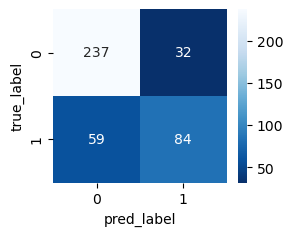

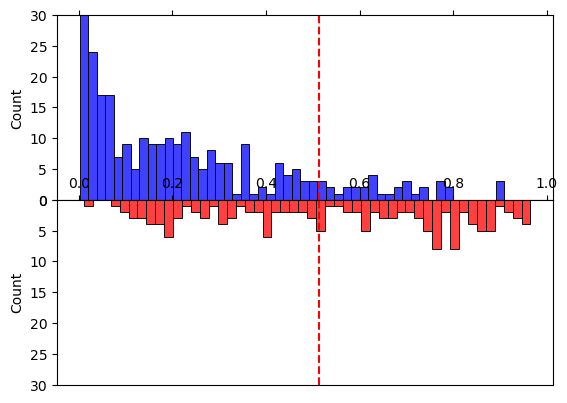

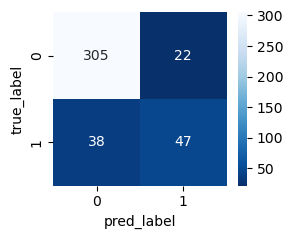

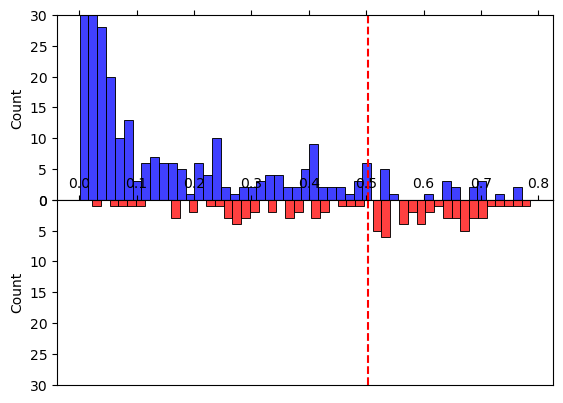

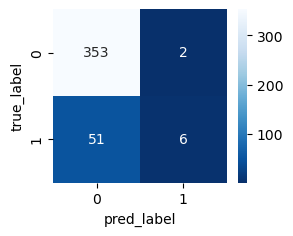

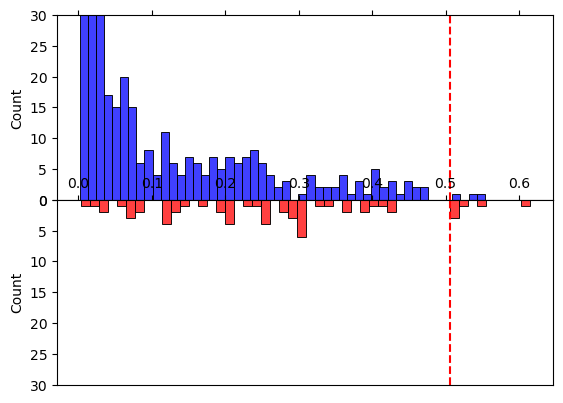

In [20]:
# Using scikit-learn API
df_probas = None

ths = []

for y_train, params in zip(ys_train, params_list):

    global x_train
    
    f = Scores()
    for ri in range(4):
        kf = KFold(n_splits=4, shuffle=True, random_state=ri)
        
        s = Scores()
        for fold, (train_indices, val_indices) in enumerate(kf.split(x_train)):
            x_train_f, x_val_f = x_train[train_indices], x_train[val_indices]
            y_train_f, y_val_f = y_train[train_indices], y_train[val_indices]
            
            model = lgb.LGBMClassifier(**params)
            model.fit(x_train_f, y_train_f)
            
            y_proba = model.predict_proba(x_val_f)

            r = Result(y_val_f, y_proba, optimize=True)
            s["acc"].append(r.acc())
            s["f1"].append(r.f1())
            s["th"].append(r.th)
            s["logloss"].append(r.logloss())
            s["cm"].append(r.cm())
            s["proba"].append(r.proba)
            s["ind"].append(val_indices)
            s["feat_imp"].append(model.feature_importances_)
            

        f |= s.fold("ind", "cm", "proba")
    a = f.ave()

    ths.append(a["th"][0])


    print(f"-- {y_train.name} --")
    print(a)
    print()
    print("- importance")

    cf = {c: f for c, f in zip(x_train.columns, a["feat_imp"][0])}
    cf = {k: v for k, v in sorted(cf.items(), key=lambda item: item[1], reverse=True)}

    for c, f in cf.items():
        print(f"{c:30}:{f}")

    Path(f"./{train_type}").mkdir(parents=True, exist_ok=True)
    with open(file=f"./{train_type}/metrics_{y_train.name}.txt", mode="w") as fh:
        print(f"-- {y_train.name} --", file=fh)
        print(a, file=fh)

        print(file=fh)
        print("- importance", file=fh)
        for c, f in cf.items():
            print(f"{c:30}:{f}", file=fh)


    fig, ax = plt.subplots()
    fig.set_figwidth(3)
    fig.set_figheight(2.25)

    ax = sns.heatmap(a["cm"][0], annot=True, cbar=True, square=True, fmt=".0f", cmap="Blues_r", xticklabels=list(range(a["cm"][0].shape[0])), yticklabels=list(range(a["cm"][0].shape[1])))
    fig.savefig(f"./{train_type}/cv_{y_train.name}.png")
    fig.show()
    ax.set_xlabel("pred_label")
    ax.set_ylabel("true_label")


    fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})

    axs[0].set_ylim(0, 30)  # invert the axis
    sns.histplot(a["proba"][0][:, 1][y_train == 0], ax=axs[0], color='blue', bins=50)
    axs[0].xaxis.tick_top()  # and move the X-Axis

    axs[1].set_ylim(axs[0].get_ylim()[::-1])  # invert the axis
    sns.histplot(a["proba"][0][:, 1][y_train == 1], ax=axs[1], color='red', bins=50)
    axs[1].xaxis.tick_top()  # and move the X-Axis
    
    axs[0].axvline(x=a["th"][0], color='r', linestyle='--')
    axs[1].axvline(x=a["th"][0], color='r', linestyle='--')

# Remove space between subplots
    fig.subplots_adjust(hspace=0)

# Show the plot
    fig.savefig(f"./{train_type}/dist_{y_train.name}.png")
    fig.show()


    df_proba = pl.Series(a["proba"][0][:, 1]).rename(y_train.name + "_prob").to_frame()
    df_proba = df_proba.with_columns(
        pl.when(pl.all() < a["th"][0])
        .then(pl.lit("N"))
        .otherwise(pl.lit("Y"))
        .name
        .map(lambda x: x[:-5] + "_pred")
    )
    if df_probas is None:
        df_probas = df_proba
    else:
        df_probas = pl.concat([df_probas, df_proba], how="horizontal")

df_pred_train = pl.concat([df_train, df_probas], how="horizontal")



In [21]:
# Using scikit-learn API
df_probas = None

for y_train, y_test, params, th in zip(ys_train, ys_test, params_list, ths):
    model = lgb.LGBMClassifier(**params)
    model.fit(x_train, y_train)

    y_proba = model.predict_proba(x_test)

    a_test = Scores()
    r = Result(y_test, y_proba)
    a_test["proba"].append(r.proba)

    df_proba = pl.Series(a_test["proba"][0][:, 1]).rename(y_test.name + "_prob").to_frame()
    df_proba = df_proba.with_columns(
        pl.when(pl.all() < th)
        .then(pl.lit("N"))
        .otherwise(pl.lit("Y"))
        .name
        .map(lambda x: x[:-5] + "_pred")

    )
    if df_probas is None:
        df_probas = df_proba
    else:
        df_probas = pl.concat([df_probas, df_proba], how="horizontal")

df_pred_test = pl.concat([df_test, df_probas], how="horizontal")


df_pred_test = pl.concat([df_pred_train, df_pred_test], how="vertical").sort("acceptedNameUsageID")
df_pred_test.write_csv(f"./{train_type}/prediction_{train_type}.csv")
